In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import calendar

In [3]:
from data_utils import StravaDataHandler, extract_fitbit_sleep

In [4]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-muted')

import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns

In [5]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [6]:
strava_handler = StravaDataHandler(csv_path='./stravadata.csv')

In [7]:
strava_handler.csv_to_df()

In [8]:
strava_handler.df.head()

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,type,start_date_local
0,3.489,180.6,NaN,9930.8,0:47:26,86.0,Run,2020-09-23T18:30:44
1,3.595,170.0,NaN,7746.9,0:35:55,81.0,Run,2020-09-21T17:57:51
2,7.588,150.9,126.4,74781.0,2:44:15,401.0,Ride,2020-09-20T13:24:11
3,3.411,169.6,NaN,11109.6,0:54:17,63.0,Run,2020-09-19T10:17:15
4,8.133,168.2,138.9,34313.0,1:10:19,77.0,Ride,2020-09-17T16:40:09


In [9]:
strava_handler.generate_total_times('moving_time')

In [10]:
strava_handler.df.head()

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,type,start_date_local,total_seconds,total_minutes
0,3.489,180.6,NaN,9930.8,0:47:26,86.0,Run,2020-09-23T18:30:44,2846,47
1,3.595,170.0,NaN,7746.9,0:35:55,81.0,Run,2020-09-21T17:57:51,2155,35
2,7.588,150.9,126.4,74781.0,2:44:15,401.0,Ride,2020-09-20T13:24:11,9855,164
3,3.411,169.6,NaN,11109.6,0:54:17,63.0,Run,2020-09-19T10:17:15,3257,54
4,8.133,168.2,138.9,34313.0,1:10:19,77.0,Ride,2020-09-17T16:40:09,4219,70


In [11]:
strava_handler.convert_from_metric()

In [12]:
strava_handler.df.head()

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,type,start_date_local,total_seconds,total_minutes,miles/sec,miles/hr
0,7.80,180.6,NaN,6.170728,0:47:26,86.0,Run,2020-09-23T18:30:44,2846,47,0.002168,7.805559
1,8.04,170.0,NaN,4.813712,0:35:55,81.0,Run,2020-09-21T17:57:51,2155,35,0.002234,8.041469
2,16.97,150.9,126.4,46.466875,2:44:15,401.0,Ride,2020-09-20T13:24:11,9855,164,0.004715,16.974201
3,7.63,169.6,NaN,6.903203,0:54:17,63.0,Run,2020-09-19T10:17:15,3257,54,0.002119,7.630190
4,18.19,168.2,138.9,21.321163,1:10:19,77.0,Ride,2020-09-17T16:40:09,4219,70,0.005054,18.192981


In [13]:
strava_handler.date_to_str()

In [14]:
strava_handler.df.head()

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,type,start_date_local,total_seconds,total_minutes,miles/sec,miles/hr,date
0,7.80,180.6,NaN,6.170728,0:47:26,86.0,Run,2020-09-23T18:30:44,2846,47,0.002168,7.805559,2020-09-23
1,8.04,170.0,NaN,4.813712,0:35:55,81.0,Run,2020-09-21T17:57:51,2155,35,0.002234,8.041469,2020-09-21
2,16.97,150.9,126.4,46.466875,2:44:15,401.0,Ride,2020-09-20T13:24:11,9855,164,0.004715,16.974201,2020-09-20
3,7.63,169.6,NaN,6.903203,0:54:17,63.0,Run,2020-09-19T10:17:15,3257,54,0.002119,7.630190,2020-09-19
4,18.19,168.2,138.9,21.321163,1:10:19,77.0,Ride,2020-09-17T16:40:09,4219,70,0.005054,18.192981,2020-09-17


In [15]:
strava_handler.subset_by_type(['Run','Ride'])

Now that we've generated some columns that we're going to be interested in, lets clean up some are missing data (i.e. missing heart rate data for activities prior to my Garmin, and watts for cycling vs running).

In [16]:
strava_handler.df['average_watts'] = np.where(strava_handler.df['average_watts'].isna(), 
                                              0, 
                                              strava_handler.df['average_watts'])

strava_handler.df['average_heartrate'] = np.where(strava_handler.df['average_heartrate'].isna(), 
                                                  0, 
                                                  strava_handler.df['average_heartrate'])

Lets check out our distributions of this data. In the scatter plot, we can see pretty clearly that there seems to be two distinct trends in the data.

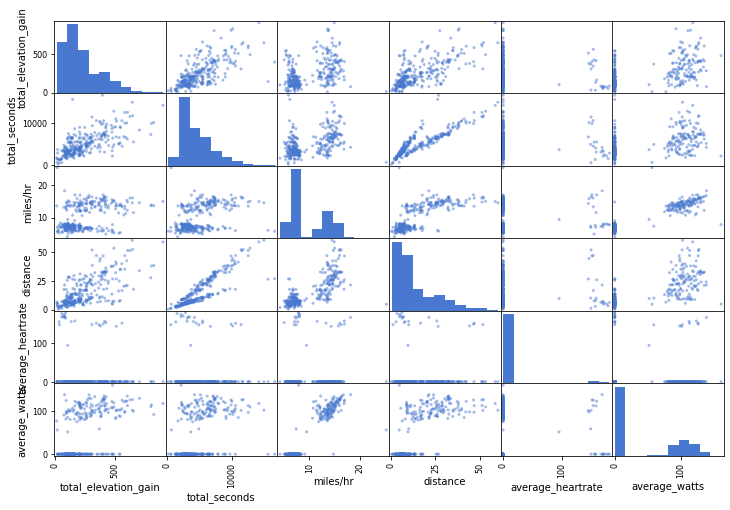

In [17]:
attributes = ['total_elevation_gain', 'total_seconds', 'miles/hr','distance', 'average_heartrate','average_watts',
            'type']
scatter_matrix(strava_handler.df[attributes], figsize=(12,8));

Text(0.5, 1.0, 'Rides and Runs')

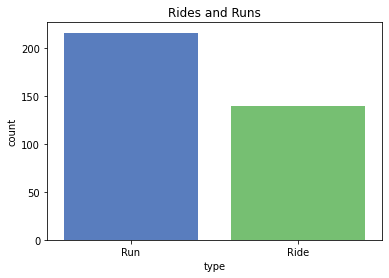

In [18]:
sns.countplot(strava_handler.df['type'])
plt.title('Rides and Runs')

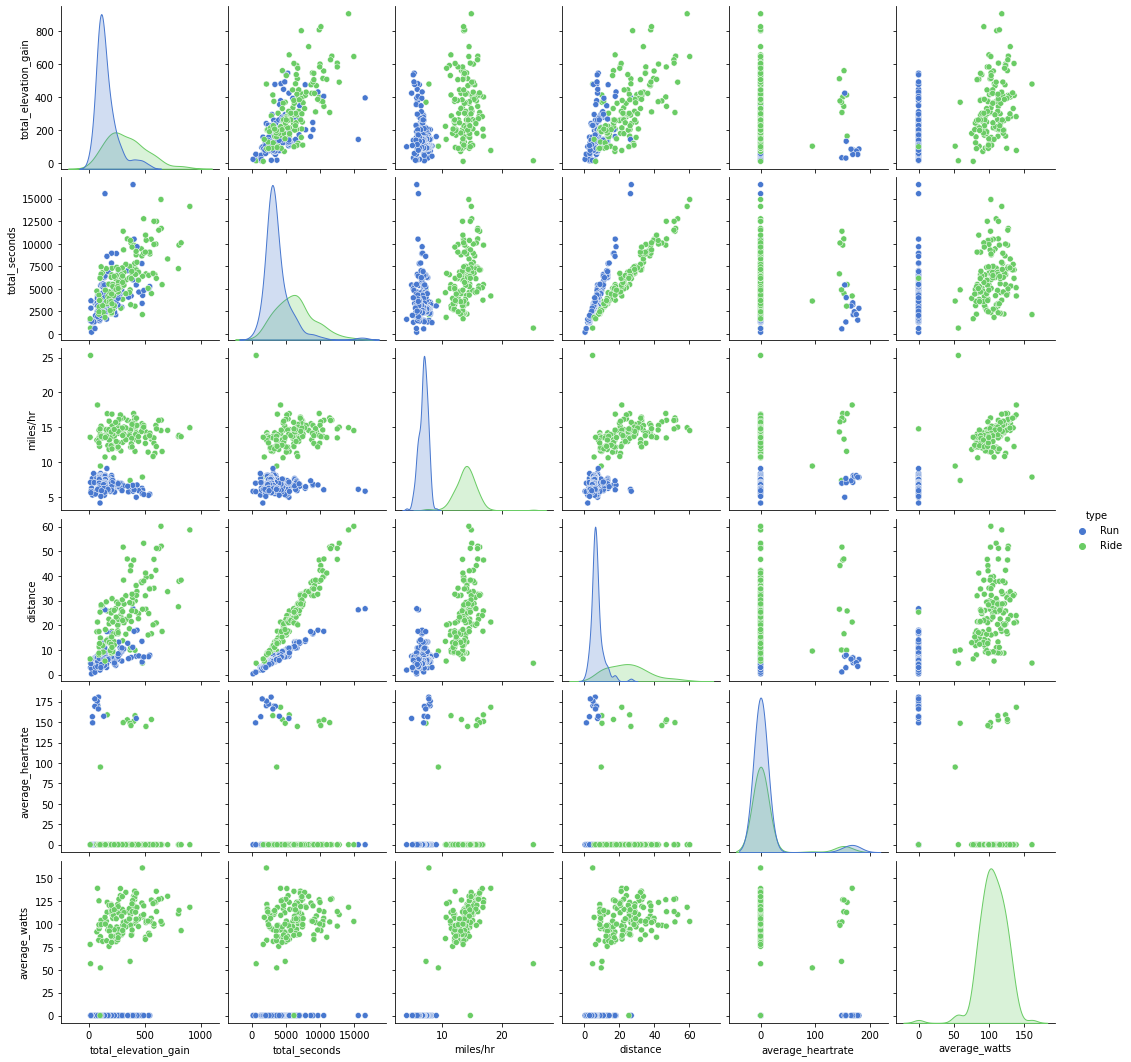

In [19]:
sns.pairplot(strava_handler.df[attributes], hue='type');

<AxesSubplot:>

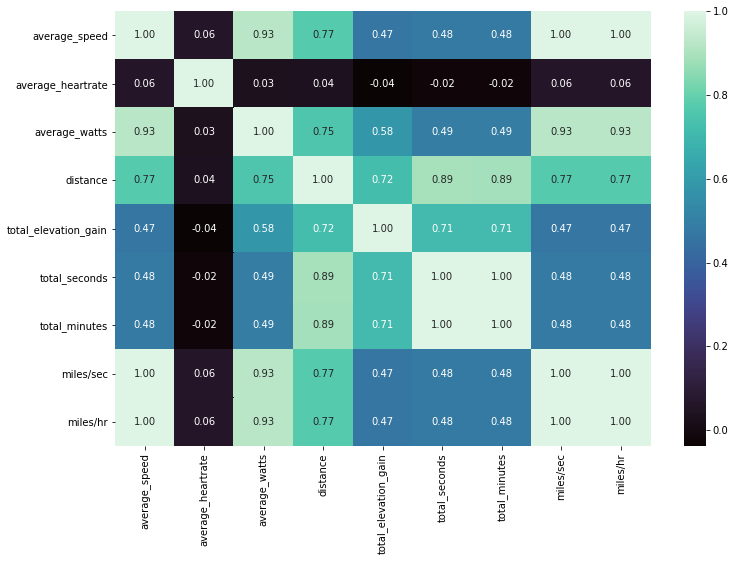

In [20]:
corr = strava_handler.df.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='mako')

In [21]:
strava_handler.df_days = strava_handler.df.copy()

In [22]:
strava_handler.df_days.set_index(pd.to_datetime(strava_handler.df_days.start_date_local), drop=True, inplace=True)

In [23]:
strava_handler.df_days['weekday'] = strava_handler.df_days.index.map(lambda x: x.weekday)

In [24]:
strava_handler.df_days.groupby('weekday').mean()

,average_speed,average_heartrate,average_watts,distance,total_elevation_gain,total_seconds,total_minutes,miles/sec,miles/hr
weekday,,,,,,,,,
0,9.980566,10.964151,43.045283,12.719583,184.241509,4134.094340,68.377358,0.002773,9.981021
1,9.444127,7.714286,37.565079,12.043846,196.860317,4095.984127,67.761905,0.002623,9.444130
2,9.071000,5.585000,31.826667,12.026481,206.263333,4263.200000,70.550000,0.002520,9.071057
3,9.736939,13.685714,39.746939,12.347757,197.614286,4069.061224,67.306122,0.002705,9.737516
4,10.681471,8.891176,56.900000,14.042962,238.000000,4441.264706,73.500000,0.002967,10.682024
5,9.549556,13.946667,44.780000,17.821622,311.717778,6181.777778,102.511111,0.002653,9.549109
6,9.763654,11.957692,43.330769,18.314861,275.134615,6168.480769,102.365385,0.002712,9.763764


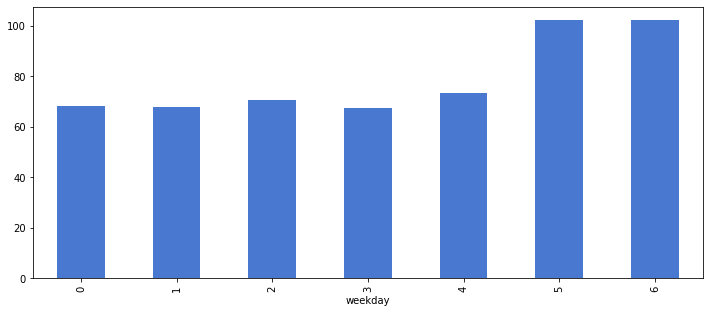

In [25]:
strava_handler.df_days.groupby('weekday').mean()['total_minutes'].plot(kind='bar', figsize=(12,5));

Text(0.5, 1.0, 'Average training time by day of the week')

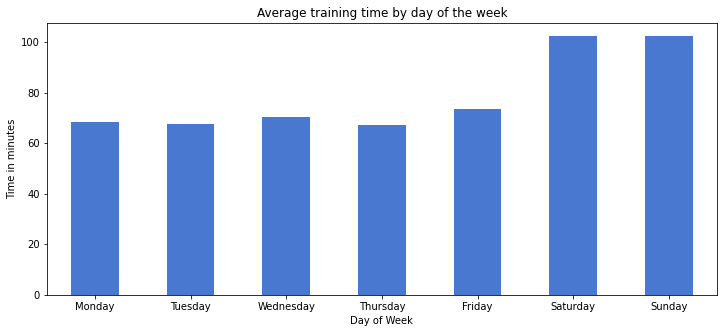

In [26]:
strava_handler.df_days.groupby('weekday').mean()['total_minutes'].plot(kind='bar', figsize=(12,5));
plt.xticks(list(range(7)), list(calendar.day_name), rotation='horizontal');
plt.xlabel('Day of Week')
plt.ylabel('Time in minutes')
plt.title('Average training time by day of the week')

In [27]:
strava_handler.df_days['year'] = strava_handler.df_days.index.map(lambda x: x.year)

In [28]:
grouped = strava_handler.df_days.groupby(['year', 'type']).mean()
grouped

average_speed  average_heartrate  average_watts   distance  \
year type                                                               
2016 Ride      13.173158           0.000000     106.336842  20.709925   
2017 Ride      13.195357           0.000000      88.085714  20.135009   
2018 Ride      14.911667           0.000000     113.908333  31.715833   
2019 Ride      13.731111           0.000000     106.622222  21.120228   
     Run        6.501039           0.000000       0.000000   5.574972   
2020 Ride      13.996296          60.200000     104.981481  22.890396   
     Run        7.084676          14.382014       0.000000   7.800210   

           total_elevation_gain  total_seconds  total_minutes  miles/sec  \
year type                                                                  
2016 Ride            248.110526    5599.947368      92.842105   0.003660   
2017 Ride            309.571429    5466.035714      90.535714   0.003665   
2018 Ride            391.745833    7665.250000     127.250000   0.004142   
2019 Ride            261.694444    5455.166667      90.555556   0.003814   
     Run             110.197403    3071.363636      50.727273   0.001806   
2020 Ride            371.611111    5783.000000      95.851852   0.003888   
     Run             181.561871    4058.021583      67.107914   0.001968   

            miles/hr   weekday  
year type                       
2016 Ride  13.175223  2.578947  
2017 Ride  13.195678  2.535714  
2018 Ride  14.912083  2.875000  
2019 Ride  13.730930  2.555556  
     Run    6.500676  2.584416  
2020 Ride  13.997421  3.814815  
     Run    7.084627  2.856115

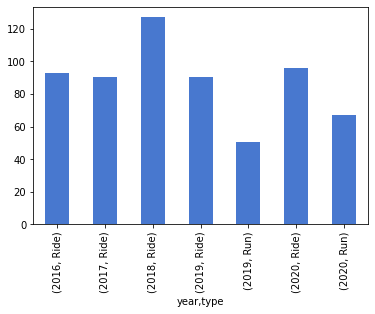

In [29]:
grouped['total_minutes'].plot(kind='bar');

In [30]:
grouped['total_minutes'].unstack('type')

type,Ride,Run
year,,
2016,92.842105,NaN
2017,90.535714,NaN
2018,127.250000,NaN
2019,90.555556,50.727273
2020,95.851852,67.107914


In [31]:
result = grouped['total_minutes'].unstack('type').fillna(0)

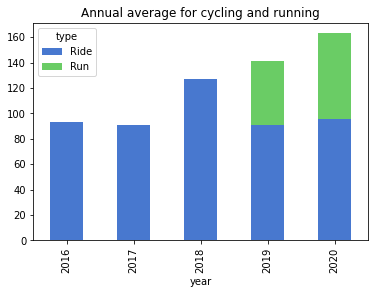

In [32]:
result.plot(kind='bar', stacked=True)
plt.title('Annual average for cycling and running');

### Cycling Clustering

In [33]:
strava_handler.ride_df = strava_handler.df[strava_handler.df['type']=="Ride"]
strava_handler.ride_df.drop(['type'], axis=1, inplace=True)
strava_handler.ride_df.head()

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,start_date_local,total_seconds,total_minutes,miles/sec,miles/hr,date
2,16.97,150.9,126.4,46.466875,2:44:15,401.0,2020-09-20T13:24:11,9855,164,0.004715,16.974201,2020-09-20
4,18.19,168.2,138.9,21.321163,1:10:19,77.0,2020-09-17T16:40:09,4219,70,0.005054,18.192981,2020-09-17
6,9.42,95.0,52.0,9.572558,1:00:58,103.0,2020-09-14T17:49:46,3658,60,0.002617,9.420778,2020-09-14
8,16.00,152.8,113.3,46.886550,2:55:48,344.0,2020-09-12T10:28:56,10548,175,0.004445,16.002235,2020-09-12
11,16.95,158.9,123.6,25.820771,1:31:25,164.0,2020-09-07T12:26:10,5485,91,0.004708,16.947088,2020-09-07


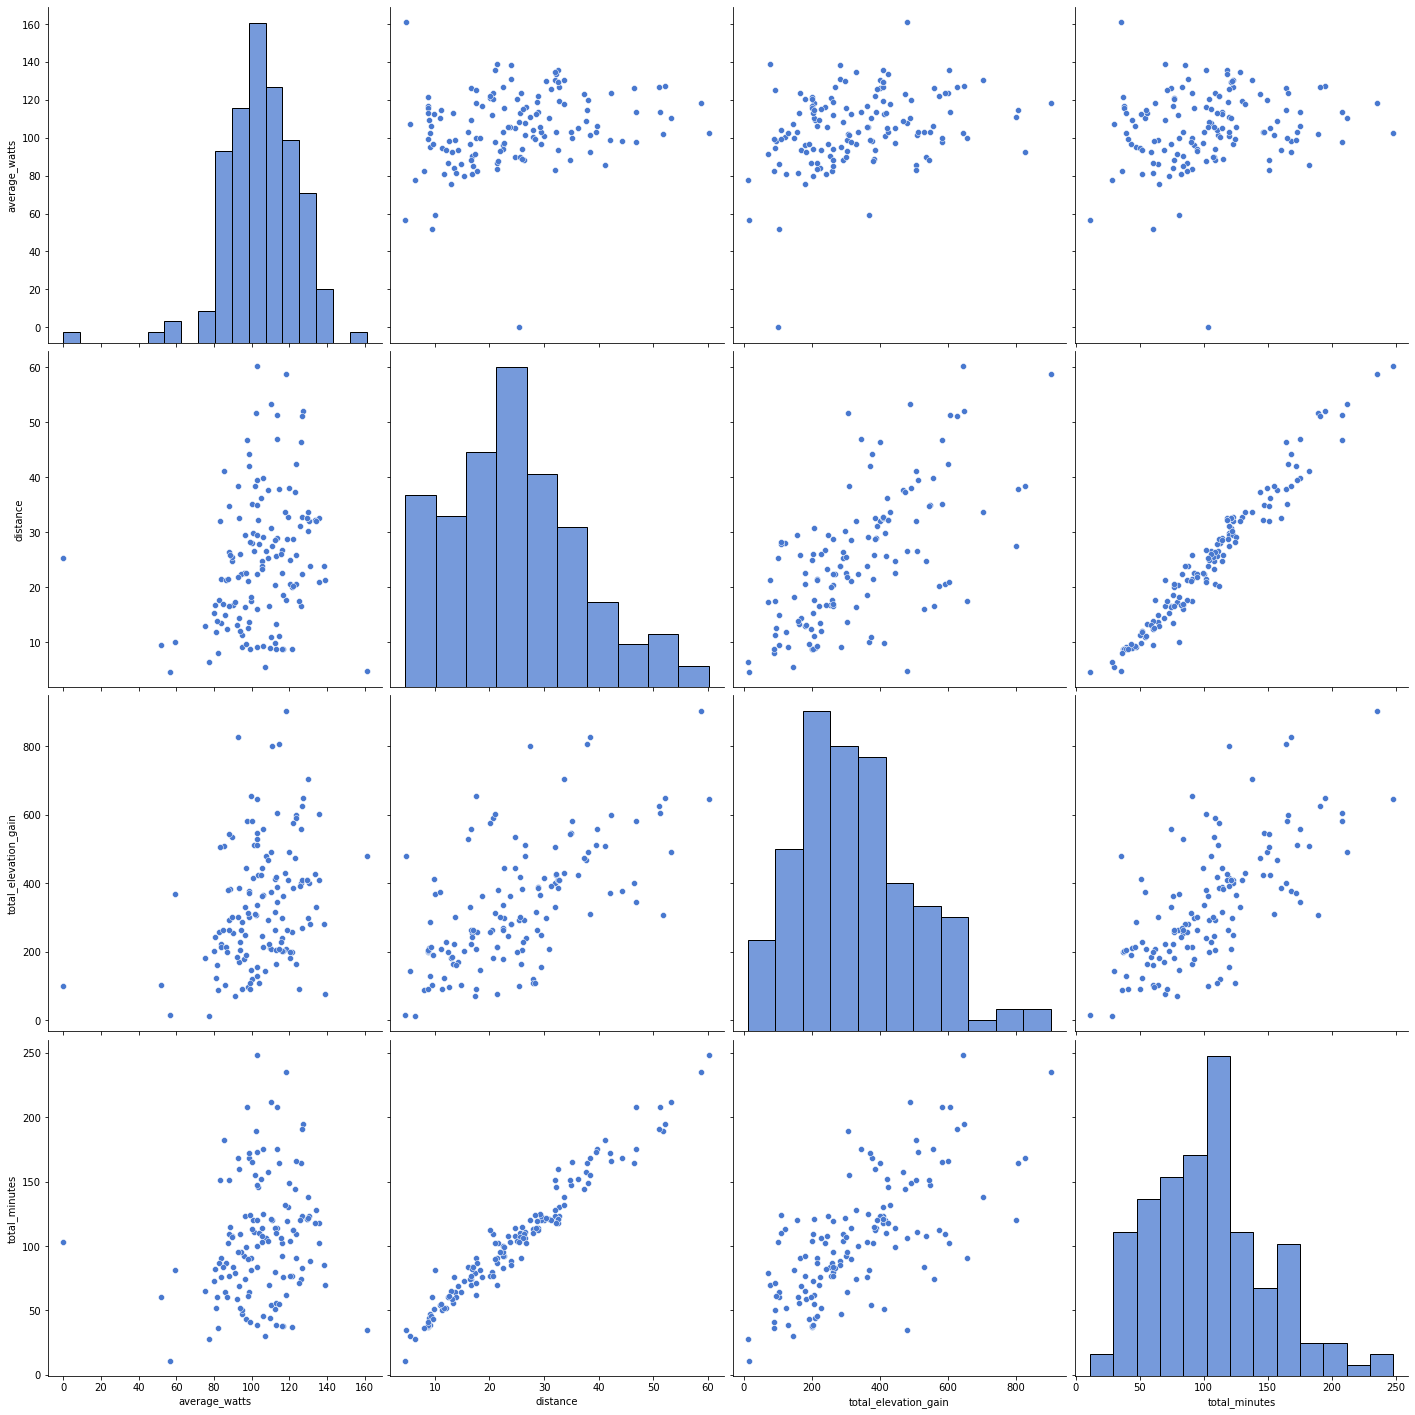

In [34]:
cols = ['average_watts', 'distance', 'total_elevation_gain','total_minutes']
sns.pairplot(x_vars=cols, y_vars=cols, data=strava_handler.ride_df, size=5);

In [35]:
strava_handler.ride_df = strava_handler.ride_df[cols]
X = StandardScaler().fit_transform(strava_handler.ride_df)

In [36]:
model = KMeans(n_clusters=4)
model.fit(X)
strava_handler.ride_df['Cluster'] = model.labels_

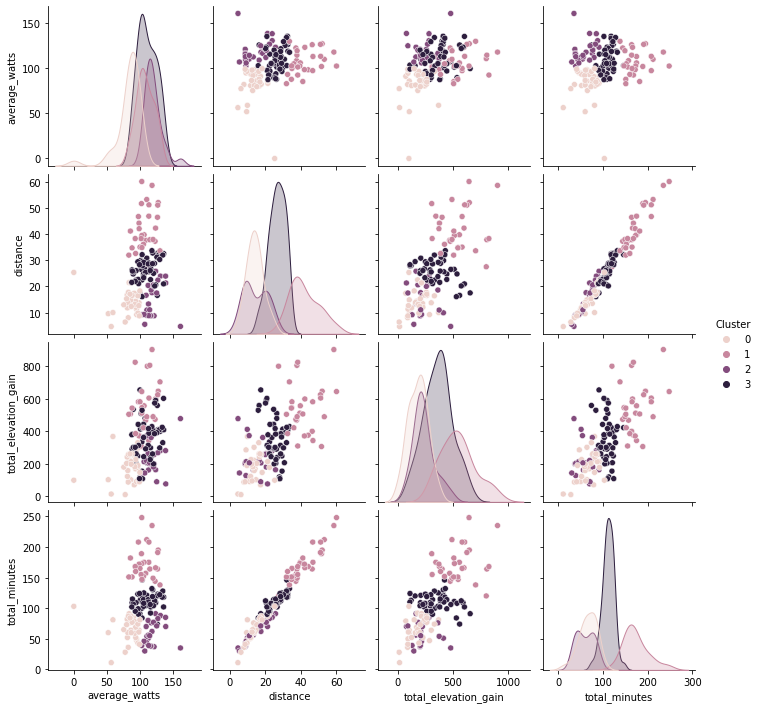

In [37]:
sns.pairplot(x_vars=cols, y_vars=cols, hue='Cluster', data=strava_handler.ride_df);

In [38]:
strava_handler.ride_df.groupby('Cluster').mean()

,average_watts,distance,total_elevation_gain,total_minutes
Cluster,,,,
0,83.151515,14.114960,180.281818,65.848485
1,107.590000,42.045224,545.236667,172.733333
2,119.452000,14.672022,231.816000,59.680000
3,110.578846,26.613128,362.078846,111.115385


In [40]:
strava_handler.ride_df.groupby('Cluster').std()

,average_watts,distance,total_elevation_gain,total_minutes
Cluster,,,,
0,19.018825,4.687024,87.274042,20.264071
1,12.956701,8.171914,155.018605,28.285409
2,12.669127,6.449903,95.663820,19.332011
3,14.051814,4.526152,128.292953,12.960958


### Running

In [41]:
strava_handler.run_df = strava_handler.df[strava_handler.df['type']=="Run"]
strava_handler.run_df.drop(['type'], axis=1, inplace=True)
strava_handler.run_df.head()

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,start_date_local,total_seconds,total_minutes,miles/sec,miles/hr,date
0,7.80,180.6,0.0,6.170728,0:47:26,86.0,2020-09-23T18:30:44,2846,47,0.002168,7.805559,2020-09-23
1,8.04,170.0,0.0,4.813712,0:35:55,81.0,2020-09-21T17:57:51,2155,35,0.002234,8.041469,2020-09-21
3,7.63,169.6,0.0,6.903203,0:54:17,63.0,2020-09-19T10:17:15,3257,54,0.002119,7.630190,2020-09-19
5,7.91,172.0,0.0,5.439932,0:41:16,74.0,2020-09-15T17:41:37,2476,41,0.002197,7.909432,2020-09-15
7,8.06,175.7,0.0,4.858638,0:36:11,74.0,2020-09-13T18:19:45,2171,36,0.002238,8.056700,2020-09-13


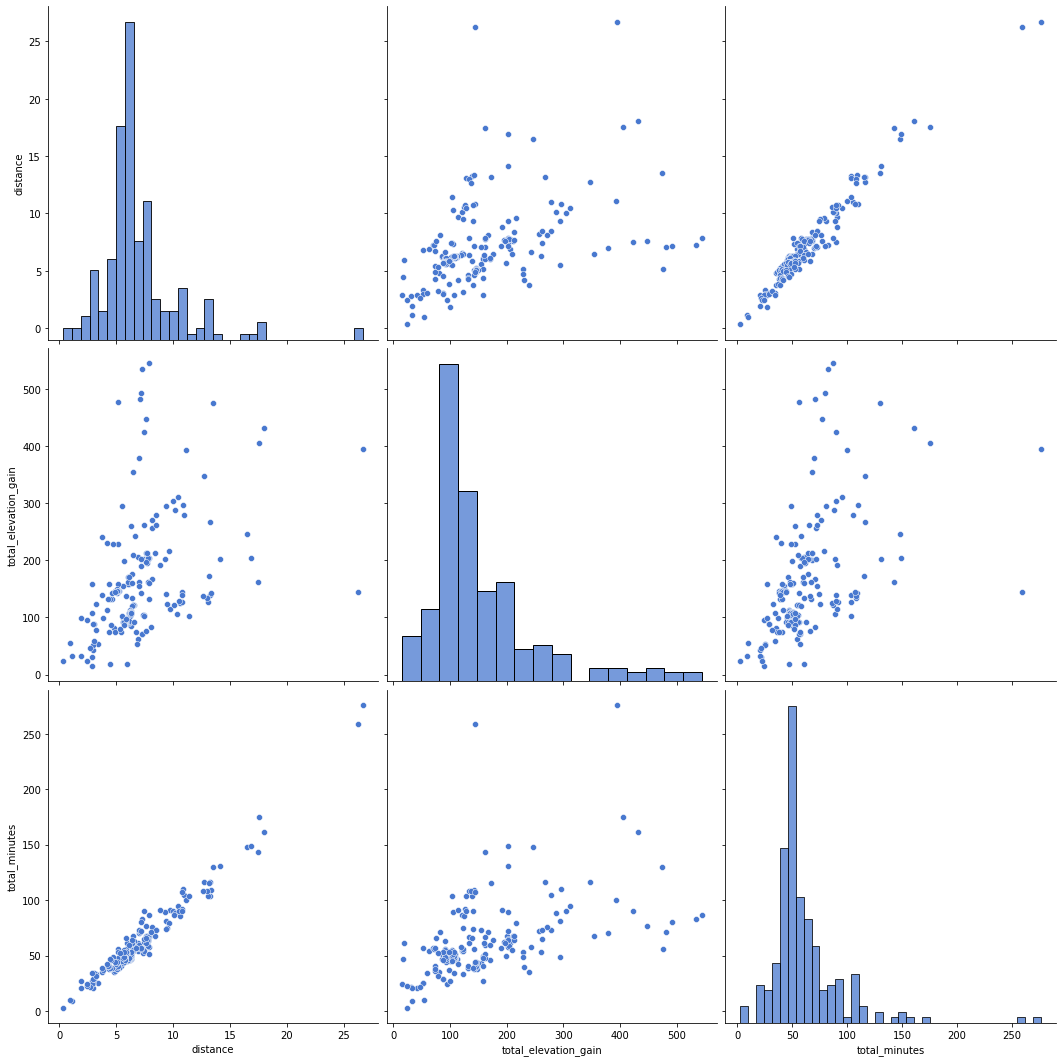

In [44]:
cols = ['distance', 'total_elevation_gain','total_minutes']
sns.pairplot(x_vars=cols, y_vars=cols, data=strava_handler.run_df, size=5);

In [45]:
strava_handler.run_df = strava_handler.run_df[cols]
X = StandardScaler().fit_transform(strava_handler.run_df)

In [47]:
model = KMeans(n_clusters=4)
model.fit(X)
strava_handler.run_df['Cluster'] = model.labels_

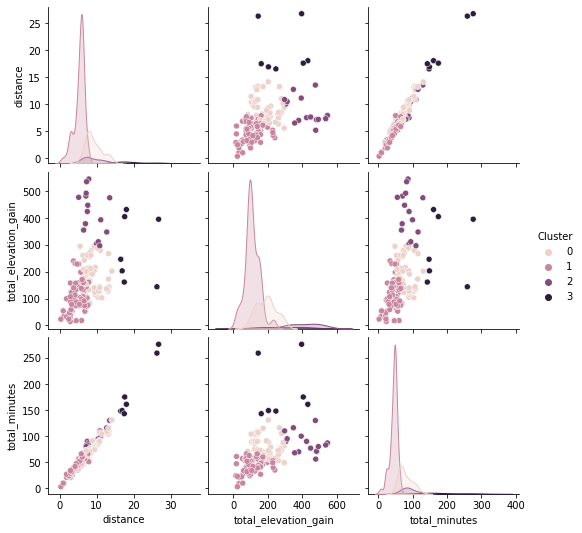

In [48]:
sns.pairplot(x_vars=cols, y_vars=cols, hue='Cluster', data=strava_handler.run_df);

In [49]:
strava_handler.run_df.groupby('Cluster').mean()

,distance,total_elevation_gain,total_minutes
Cluster,,,
0,9.130315,189.746429,78.839286
1,5.296937,107.587681,44.818841
2,8.782921,417.520000,88.200000
3,19.926181,283.800000,187.285714


In [50]:
strava_handler.run_df.groupby('Cluster').std()

,distance,total_elevation_gain,total_minutes
Cluster,,,
0,2.153884,55.307241,19.135666
1,1.414782,41.373380,11.026998
2,2.467353,83.214432,19.785276
3,4.524061,123.322180,56.014029
